In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [84]:
#Lectura de datos 
data = pd.read_csv('DEPURACION_FINAL.csv', sep=',')
data

,AÑO,MES,DIA,FECHA,HORA,KW-H
0,2015,1,jueves,1,0,3200
1,2015,1,jueves,1,1,3200
2,2015,1,jueves,1,2,2400
3,2015,1,jueves,1,3,2400
4,2015,1,jueves,1,4,2400
...,...,...,...,...,...,...
43819,2019,12,martes,31,19,3400
43820,2019,12,martes,31,20,3600
43821,2019,12,martes,31,21,3800
43822,2019,12,martes,31,22,4000


In [85]:
#Verificacion de nans 
data.isnull().values.any()
data.isnull().sum().sum()

data.isnull().sum()

AÑO      0
MES      0
DIA      0
FECHA    0
HORA     0
KW-H     0
dtype: int64

In [86]:
#Variable categrica DIA a numérica
#TODO Borrar al final de cuentas no se usa este dato 
data['DIA'] = data['DIA'].map({'lunes': 1 ,
                                           'martes': 2,
                                           'miercoles': 3,
                                           'miércoles': 3,
                                           'jueves': 4 , 
                                           'viernes': 5, 
                                           'sábado': 6,
                                           'sabado': 6,  #inconsistencia en la data por las tildes
                                           'domingo': 7})




In [138]:
data.tail(50)
# data.to_csv('data_total.csv')


In [88]:
#Llevamos la hora y la fecha para los indices porque lo que nos interesa es KW-H
from datetime import datetime 
data_final = pd.DataFrame()
fechas_dt = []
kwh_dt = []
for registro in data.values:
    fecha = "{}-{}-{} {}".format(registro[0], registro[1], registro[3], registro[4])
    fecha_dt = datetime.strptime(fecha, '%Y-%m-%d %H')
    fechas_dt.append(fecha_dt)
    kwh_dt.append(registro[5])
#Creamos un nuevo dataframe con el formato de fecha correcto y el valor de KW-H
data_final['FECHA'] = fechas_dt
data_final['KW-H'] = kwh_dt
data_final

,FECHA,KW-H
0,2015-01-01 00:00:00,3200
1,2015-01-01 01:00:00,3200
2,2015-01-01 02:00:00,2400
3,2015-01-01 03:00:00,2400
4,2015-01-01 04:00:00,2400
...,...,...
43819,2019-12-31 19:00:00,3400
43820,2019-12-31 20:00:00,3600
43821,2019-12-31 21:00:00,3800
43822,2019-12-31 22:00:00,4000


In [139]:
data_final.to_csv('data_total_dattime.csv')

In [89]:
#Llevamos la FECHA al indice de nuestro df, ahora solo tenemos una columna de datos
data_final.set_index('FECHA', drop=True, inplace = True)
data_final

,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2019-12-31 19:00:00,3400
2019-12-31 20:00:00,3600
2019-12-31 21:00:00,3800


In [90]:
#Dividir los datos de entrenamiento y de test
# No se puede utilizar train test split, debemos dividir en el ultimo segmento 
#Tomamos los datos para validacion el 18%, pero del final de los datos (todo 2019 menos enero)
size = int(0.18292*data_final.shape[0])
data_test = data_final[-size:]
data_train = data_final[:-size]
data_train


,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2019-01-31 19:00:00,3300
2019-01-31 20:00:00,3300
2019-01-31 21:00:00,3400


In [91]:
#Transformacion de datos a numerica

data_train['KW-H'] = [valor.replace(",", ".") for valor in data_train['KW-H'] ]
data_train['KW-H'] = [float(valor) for valor in data_train['KW-H'] ]

data_test['KW-H'] = [valor.replace(",", ".") for valor in data_test['KW-H'] ]
data_test['KW-H'] = [float(valor) for valor in data_test['KW-H'] ]

data_train

/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher

,KW-H
FECHA,
2015-01-01 00:00:00,3200.0
2015-01-01 01:00:00,3200.0
2015-01-01 02:00:00,2400.0
2015-01-01 03:00:00,2400.0
2015-01-01 04:00:00,2400.0
...,...
2019-01-31 19:00:00,3300.0
2019-01-31 20:00:00,3300.0
2019-01-31 21:00:00,3400.0


In [92]:
#Normalizacion de los datos
#Para LSTM es obligatoria la normalización, en este caso lo hacemos de 0 a 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_train_scaled = sc.fit_transform(data_train)
print(data_train_scaled.shape)
data_train_scaled
 


(35808, 1)


array([[0.66666667],
       [0.66666667],
       [0.5       ],
       ...,
       [0.70833333],
       [0.75      ],
       [0.54166667]])

In [93]:
#Tenemos que entrenar la red por bloques de datos 
#Time_step es el tamaño del bloque 
#Cada n datos genera una salida 
#Tomamos bloques de 60 datos consecutivos 
time_step = 60 
X_train = [] #Lista de conjuntos de 60 datos 
Y_train = []
m = len(data_train_scaled)
for i in range(time_step, m):
    X_train.append(data_train_scaled[i-time_step:i, 0]) #Guardamos 60 valores
    Y_train.append(data_train_scaled[i, 0]) #Buscamos predecir el dato time_step + 1, no la var KW
X_train, Y_train = np.array(X_train), np.array(Y_train) #Usamos np por reshape y optimizacion



In [94]:
X_train.shape, Y_train.shape

((35748, 60), (35748,))

In [95]:
# pd.DataFrame(X_train).to_csv('x_train.csv')
# pd.DataFrame(Y_train).to_csv('y_train.csv')

In [14]:
#Obligatorio el reshape de los datos, es obligatorio por Keras, nos pide ingresar un array de 3 dim
#Llevamos de dos a 3 dimensiones nuestro arreglo 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Agregamos una nueva dimension
X_train.shape, Y_train.shape

((35748, 60, 1), (35748,))

In [15]:
#MODELO
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


In [16]:
#rmsprop LOS MEJORES RESULTADOS
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 10


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
model.add(Dropout(0.4))
# #Capa 2
model.add(LSTM(units=4))
# model.add(Dropout(0.2))


#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 64)

2022-01-21 18:18:47.786809: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-21 18:18:47.787894: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
35748/35748 [==============================] - 112s 3ms/step - loss: 0.0173 - mean_absolute_error: 0.0841
Epoch 2/10
35748/35748 [==============================] - 171s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0505
Epoch 3/10
35748/35748 [==============================] - 165s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0421
Epoch 4/10
35748/35748 [==============================] - 157s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0384
Epoch 5/10
35748/35748 [==============================] - 157s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0367
Epoch 6/10
35748/35748 [==============================] - 165s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0360
Epoch 7/10
35748/35748 [==============================] - 161s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0352
Epoch 8/10
35748/35748 [==============================] - 158s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0346
Epoch 9/10
35748/35748 [==============================] - 169s 5

In [17]:
data_test

,KW-H
FECHA,
2019-02-01 00:00:00,2500.0
2019-02-01 01:00:00,2500.0
2019-02-01 02:00:00,2200.0
2019-02-01 03:00:00,2200.0
2019-02-01 04:00:00,2200.0
...,...
2019-12-31 19:00:00,3400.0
2019-12-31 20:00:00,3600.0
2019-12-31 21:00:00,3800.0


In [18]:
x_test  = data_test.values
x_test = sc.transform(x_test)
# # x_test
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

In [19]:
len(prediccion)

7956

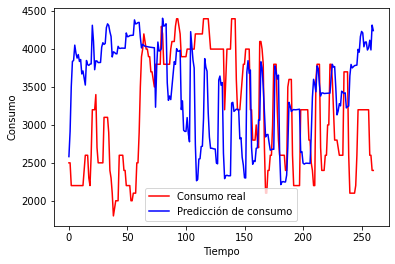

In [103]:
#Grafica de valores
# Y_test #Aun no defnido 
plt.plot(data_test.values[:261], color='red', label='Consumo real')
plt.plot(prediccion[:261], color='blue', label='Predicción de consumo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

[[<matplotlib.axis.XTick at 0x7f7b6c338910>,

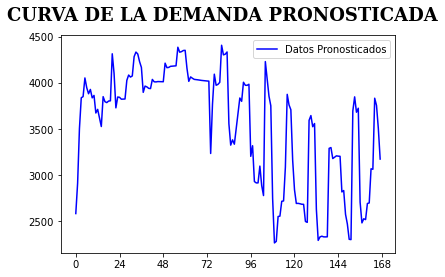

In [37]:
# Figura 5.8: Curva de la demanda eléctrica pronosticada
#Los primeros 7 dias de febrero
prediccion_febrero = prediccion[:168]
fig, ax_58 = plt.subplots()
ax_58.plot(prediccion_febrero, 
           color='blue', 
           label='Datos Pronosticados')
plt.suptitle('CURVA DE LA DEMANDA PRONOSTICADA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
# plt.xlabel('1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 7 7 7')
plt.legend()
ax_58.set(xticks =range(0, len(prediccion_febrero)+ 1, 24))
# plt.show()


In [42]:
prediccion_febrero_df = pd.DataFrame(prediccion_febrero, columns = ['KW-H PRED'])
prediccion_febrero_df.describe()

,KW-H PRED
count,168.000000
mean,3541.908447
std,622.003052
min,2264.079346
25%,3066.260010
50%,3796.951172
75%,4019.773682
max,4406.853027


In [46]:
# Tabla 5.2: Análisis descriptiva con datos reales de la demanda eléctrica
data_pred_febr =prediccion_febrero_df['KW-H PRED']
maximo = np.max(data_pred_febr)
print('Máximo = {}'.format(maximo))
minimo = np.min(data_pred_febr)
print('Mínimo = {}'.format(minimo))
# q75, q25 = np.percentile(data_estudio['KW-H'], [75, 25])
# rango = q75 - q25
rango = maximo - minimo
print('Rango = {}'.format(rango))
media = np.mean(data_pred_febr)
print('Media = {}'.format(media))
mediana = data_pred_febr.median()
print('Mediana = {}'.format(mediana))
varianza = data_pred_febr.var()
print('Varianza = {}'.format(varianza))
std = np.std(data_pred_febr)
print('Desviación Estándar = {}'.format(std))
coef_var = np.std(data_pred_febr) /np.mean(data_pred_febr) * 100
print('Coeficiente de variación = {} %'.format(coef_var))
# lim_max, lim_min = np.percentile((data_pred_febr), [75, 25])
lim_max = media + 1 * std
lim_min = media - 1 * std
print('Límite máximo = {}'.format(lim_max))
print('Límite mínimo = {}'.format(lim_min))

data_pred_febr.describe()

Máximo = 4406.85302734375
Mínimo = 2264.079345703125
Rango = 2142.773681640625
Media = 3541.908447265625
Mediana = 3796.951171875
Varianza = 386887.78125
Desviación Estándar = 620.1490478515625
Coeficiente de variación = 17.508895474989515 %
Límite máximo = 4162.0574951171875
Límite mínimo = 2921.7593994140625


count     168.000000
mean     3541.908447
std       622.003052
min      2264.079346
25%      3066.260010
50%      3796.951172
75%      4019.773682
max      4406.853027
Name: KW-H PRED, dtype: float64

In [47]:
#Funciones
def funcionConstante(x, constante):
    return constante

[[<matplotlib.axis.XTick at 0x7f7b6aef9d10>,

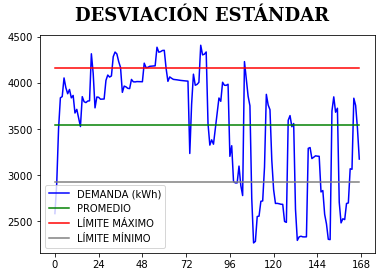

In [70]:
# Figura 5.9: Desviación estándar con datos de la demanda pronosticada

datos_kwh = data_pred_febr



fig, ax_59 = plt.subplots()

ax_59.plot(datos_kwh, 
         color = 'blue', 
         label = 'DEMANDA (kWh)')
ax_59.plot([funcionConstante(x, media) for x in datos_kwh], 
         color = 'green', 
         label = 'PROMEDIO')

ax_59.plot([funcionConstante(x, lim_max) for x in datos_kwh], 
         color = 'red', 
         label = 'LÍMITE MÁXIMO')

ax_59.plot([funcionConstante(x, lim_min) for x in datos_kwh], 
         color = 'gray', 
         label = 'LÍMITE MÍNIMO')
# ax_59.fill_between([funcionConstante(x, lim_max) for x in datos_kwh], 
#                    [funcionConstante(x, lim_min) for x in datos_kwh],
#                    alpha = .5,
#                    linewidth = 0
#                   )

plt.suptitle('DESVIACIÓN ESTÁNDAR',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
# plt.xlabel('1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 7 7 7')
plt.legend()
ax_59.set(xticks =range(0, len(prediccion_febrero)+ 1, 24))

In [72]:
#Exportacion de datos para sixpack capability system
data_pred_febr.to_csv('prediccion_febrero.csv')
data_pred_febr

0      2582.288086
1      2911.652100
2      3502.538574
3      3837.328125
4      3849.942383
          ...     
163    3062.572266
164    3832.619385
165    3754.178711
166    3504.527100
167    3173.098633
Name: KW-H PRED, Length: 168, dtype: float32

[[<matplotlib.axis.XTick at 0x7f7b6e258c90>,

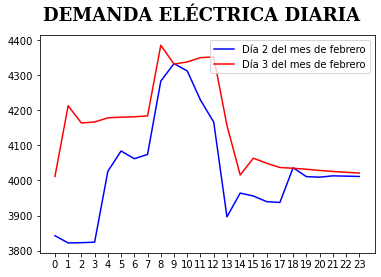

In [96]:
# Figura 5.11: Demanda eléctrica diaria con datos obtenidos del pronostico
# KW-H vs Hora del dia 
datos_kwh
fig, ax_511 = plt.subplots()
serie = range(0,24)
ax_511.plot(serie,
            datos_kwh[24:48],
         color = 'blue', 
         label = 'Día 2 del mes de febrero')

ax_511.plot(serie, 
            datos_kwh[48:72], 
         color = 'red', 
         label = 'Día 3 del mes de febrero')

plt.suptitle('DEMANDA ELÉCTRICA DIARIA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
ax_511.set(xticks = serie)


In [99]:
# exportamos los datos del dia 3 del mes de febrero 
datos_tres_febrero = datos_kwh[48:72]
datos_tres_febrero.to_csv('datos_tresFeb_pred.csv')


In [100]:
datos_tres_febrero.describe()

count      24.000000
mean     4146.682129
std       126.889633
min      4011.190674
25%      4030.996460
50%      4160.245361
75%      4190.992554
max      4385.215332
Name: KW-H PRED, dtype: float64

In [115]:
mes = 1
fecha_inicio = 25
fecha_fin = 31
year = 2019
data_cuar_sem_dic = data[(data['FECHA'] >=fecha_inicio) &  
                         (data['MES'] == mes )& 
                         (data['AÑO'] == year)]
data
data_cuar_sem_dic['KW-H']
data_pred_febr

0      2582.288086
1      2911.652100
2      3502.538574
3      3837.328125
4      3849.942383
          ...     
163    3062.572266
164    3832.619385
165    3754.178711
166    3504.527100
167    3173.098633
Name: KW-H PRED, Length: 168, dtype: float32

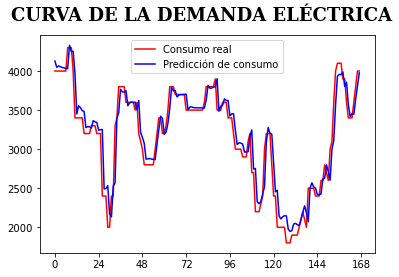

In [132]:
# Figura 5.13: Curva de la demanda eléctrica real vs pronosticada
#Pronostico para los ultimos 7 dias de la data de prueba

fig, ax_511 = plt.subplots()
rango = range(0, len(data_pred_febr)+1, 24)
ax_511.plot(data_test.values[-24*7:], 
         color='red', 
         label='Consumo real')
ax_511.plot(prediccion[-24*7:], 
         color='blue', 
         label='Predicción de consumo')
plt.suptitle('CURVA DE LA DEMANDA ELÉCTRICA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
ax_511.set(xticks = rango)
plt.show()

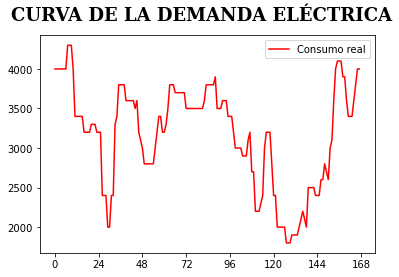

In [137]:
#Gráfica de error entre curva de la demanda eléctrica real y pronosticada (semanal)
fig, ax_511 = plt.subplots()
rango = range(0, len(data_pred_febr)+1, 24)
x = range(0, 24*7)
yerror = [0.01, 0.0336]
plt.errorbar(x, 
             data_test.values[-24*7:], 
#              yerr = yerror,
             color='red', 
             label='Consumo real')
# plt.plot(prediccion[-24*7:], 
#          color='blue', 
#          label='Predicción de consumo')
plt.suptitle('CURVA DE LA DEMANDA ELÉCTRICA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
ax_511.set(xticks = rango)
plt.show()